### Create Synthetic Datasets
---

This notebook is used to generate simple sinusoidal synthetic datasets with a specified numbers of worms, named neurons, and other characteristics of real datasets.

*Last update: 3 November 2023*

#### Libraries and helper functions
---

In [1]:
import torch
import pickle
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils import NEURONS_302
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data

Defaulting to CPU.


In [2]:
def plot_signals(data, time_tensor, neuron_idx=None, yax_limit=True, suptitle=None):
    assert isinstance(data, torch.Tensor), "data must be a PyTorch tensor"
    assert isinstance(time_tensor, torch.Tensor), "time_tensor must be a PyTorch tensor"
    assert data.dim() == 2, "data must be a 2D tensor"
    assert isinstance(neuron_idx, (int, list)), "neuron_idx must be an integer or list"

    time_tensor = time_tensor.squeeze()
    assert data.size(0) == time_tensor.size(
        0
    ), "Number of rows in data and time_tensor must match"

    num_neurons = data.size(1)

    # Randomly select the column indices if not provided
    if isinstance(neuron_idx, int):
        assert (
            neuron_idx <= num_neurons
        ), "neuron_idx cannot exceed the number of neurons"
        column_indices = np.random.choice(num_neurons, neuron_idx, replace=False)
    elif isinstance(neuron_idx, list):
        assert (
            len(neuron_idx) <= num_neurons
        ), "neuron_idx cannot exceed the number of neurons"
        column_indices = np.array(neuron_idx)

    num_columns = len(column_indices)

    # Extract the selected columns from the data tensor
    selected_columns = data[:, column_indices]

    # Define the color palette using scientific colors
    colors = sns.color_palette("bright", num_columns)

    # Plotting subplots vertically
    fig, axs = plt.subplots(num_columns, 1, figsize=(15, num_columns))
    fig.tight_layout(pad=0.0)

    for i, ax in enumerate(axs):
        ax.plot(time_tensor, selected_columns[:, i], color=colors[i])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        if yax_limit:
            ax.set_ylim(-1.0, 1.0)
        ax.set_ylabel("{}".format(NEURONS_302[column_indices[i]]))

        if i < num_columns - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel("Time (s)")

    # Add a super title to the figure if provided
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(pad=1)

    plt.show()

In [3]:
def plot_3d_trajectory(
    X, axis_labels=("X Axis", "Y Axis", "Z Axis"), title="3D Trajectory", show=True
):
    """
    Plot a 3D trajectory from a dataset.

    Parameters:
    - X: A 2D numpy array of shape (max_timesteps, 3) containing the trajectory data.
    - axis_labels: A tuple containing the labels for the axes. Default is ('X Axis', 'Y Axis', 'Z Axis').
    - title: Title of the plot.
    - show: If True, the plot will be displayed. If False, the plot object will be returned.

    Returns:
    - fig, ax: The figure and axis objects of the plot if show is False.
    """
    max_timesteps = X.shape[0]

    # Create a new figure for the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Extract x, y, z coordinates from the data
    x, y, z = X[:, 0], X[:, 1], X[:, 2]

    # Create a color map based on the time progression
    norm = plt.Normalize(0, max_timesteps)
    colors = plt.cm.viridis(norm(np.arange(max_timesteps)))

    # Plot the 3D trajectory with a color gradient
    for i in range(1, len(x)):
        ax.plot(
            x[i - 1 : i + 1],
            y[i - 1 : i + 1],
            z[i - 1 : i + 1],
            color=colors[i],
            lw=0.5,
        )

    # Mark the start of the trajectory with a green star
    ax.plot([x[0]], [y[0]], [z[0]], "g*", markersize=8)

    # Mark the end of the trajectory with a red circle
    ax.plot([x[-1]], [y[-1]], [z[-1]], "ro", markersize=7)

    # Set labels for the axes
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    ax.set_zlabel(axis_labels[2])

    # Set title
    ax.set_title(title)

    # Show the plot
    if show:
        plt.show()
    else:
        return fig, ax

In [4]:
def time_delay_embedding(x, delay, dimension):
    """
    Constructs a time-delay embedding matrix from time series data.

    :param x: Time series data as a 1D numpy array.
    :param delay: The delay \(\tau\) between time series elements in the embedding.
    :param dimension: The embedding dimension \(m\).
    :return: The time-delay embedded data as a 2D numpy array.
    """
    n = len(x)
    if n < (dimension - 1) * delay + 1:
        raise ValueError(
            "Time series data is too short for the given delay and dimension."
        )
    m = n - (dimension - 1) * delay
    embedded_data = np.empty((m, dimension))
    for i in range(m):
        for j in range(dimension):
            embedded_data[i, j] = x[i + j * delay]
    return embedded_data

In [5]:
def lorenz(X, t, sigma=10.0, beta=8.0 / 3, rho=28.0):
    """The Lorenz equations."""
    x, y, z = X
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

In [6]:
def save_synthetic_dataset(file_name, dataset):
    with open(file_name, "wb") as f:
        pickle.dump(dataset, f)

#### Sines dataset
---

In [7]:
def create_synthetic_dataset_sines(
    max_timesteps=1000,
    num_worms=1,
    num_signals=302,
    num_named_neurons=1,
    add_noise=False,
    noise_std=0.01,
    sum_frequencies=1,
    random_freqs=False,
    delta_seconds=0.7,
    smooth_method="GA",
    transform=StandardScaler(),
    dataset_name="Sines0000",
):
    """
    Create a synthetic worm datasets using a sum of sinusoidal functions.
    Out of the `num_signals` neurons, `num_named_neurons` neurons are chosen randomly
    to have non-zero (i.e. "measured") signals. Each neuron's calcium signal is a sinusoid
    with `sum_frequencies` frequencies added together and a random phase.

    :param seq_len: The sequence length of the synthetic data.
    :param num_worms: The number of worms to create datasets for.
    :param num_signals: The number of signals, corresponds to number of neurons.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param add_noise: If True, add Gaussian noise to the synthetic data. Otherwise, do not add noise.
    :param noise_std: The sklearn transform to use for normalizing the data.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param random_freqs: If True, use random frequencies for each neuron. Otherwise, use the same frequencies for all neurons.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: Standard deviation of the Gaussian noise.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # this will be consistent across worms

    # Calculation of unknown neurons
    num_unknown_neurons = num_signals - num_named_neurons

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # this will vary across worms

        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        for i in named_neuron_indices:
            neuron_name = NEURONS_302[i]

            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                np.clip(
                    np.round(np.random.random(sum_frequencies) / 10, 2), 0, 0.1
                ).tolist()  # random frequencies
                if random_freqs
                else np.clip(
                    np.round(np.arange(sum_frequencies + 1) / 100, 2), 0, 0.1
                ).tolist(),  # deterministic frequencies
            )

            phases = neuron_to_phases.setdefault(
                neuron_name,
                [
                    np.random.random() * 2 * np.pi  # random phase
                    for _ in range(sum_frequencies)
                ],
            )

            time_points = np.arange(max_timesteps)

            # Add sine functions
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, i] += np.sin(2 * np.pi * freq * time_points + phase)

            # Add noise
            if add_noise:
                calcium_data[:, i] += np.random.normal(0, noise_std, max_timesteps)

        # Normalize data
        calcium_data = transform.fit_transform(calcium_data)

        # Calculate residuals
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        resample_dt = np.round(np.median(dt).item(), 2)
        residual_calcium = np.gradient(calcium_data, axis=0) / dt

        # Smooth the data
        if smooth_method is not None:
            smooth_calcium_data = smooth_data_preprocess(
                calcium_data, time_in_seconds, smooth_method
            )
            smooth_residual_calcium = smooth_data_preprocess(
                residual_calcium, time_in_seconds, smooth_method
            )
        else:
            smooth_calcium_data = calcium_data
            smooth_residual_calcium = residual_calcium

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = max_timesteps
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)

        # Save the data
        dataset[worm] = worm_data

    return dataset

In [10]:
# Initialize parameters
max_timesteps = 3000
num_worms = 1
num_named_neurons = 5
add_noise = True
noise_std = 0.1
file_name = "Sines0000"
sum_frequencies = 1
random_freqs = False
delta_seconds = 0.5
smooth_method = None  # "GA"

# Creating and saving datasets
dataset = create_synthetic_dataset_sines(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=302,
    num_named_neurons=num_named_neurons,
    add_noise=add_noise,
    noise_std=noise_std,
    sum_frequencies=sum_frequencies,
    random_freqs=random_freqs,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=StandardScaler(),
    dataset_name=file_name,
)

# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][
    :num_named_neurons
]

# Save the dataset
save_synthetic_dataset(f"processed/neural/{file_name}.pickle", dataset)

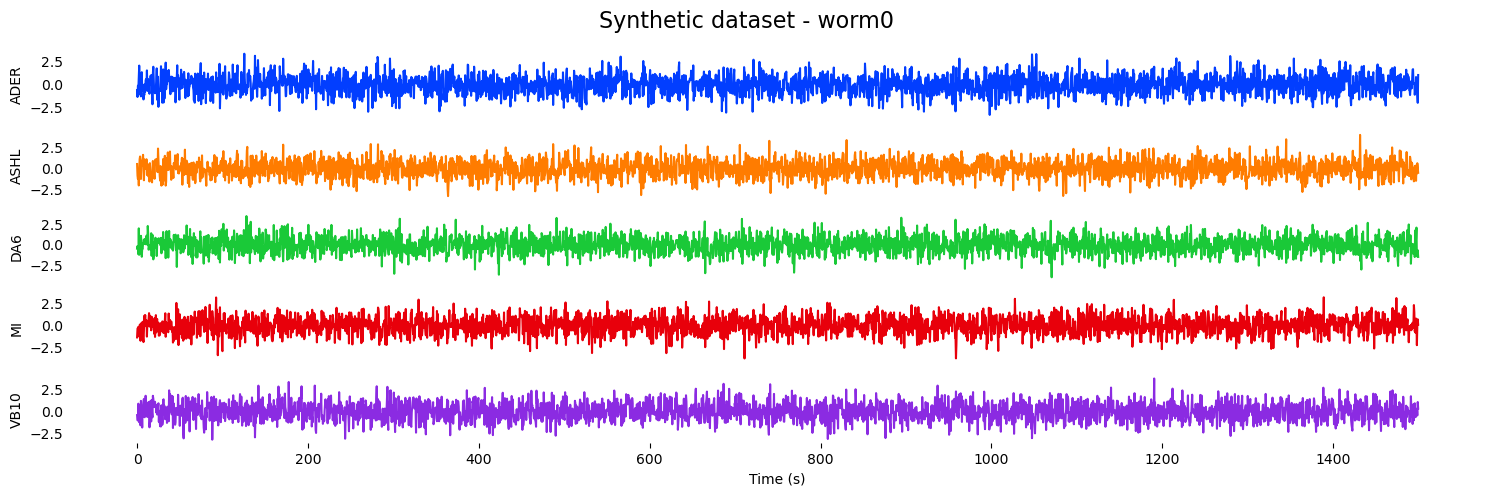

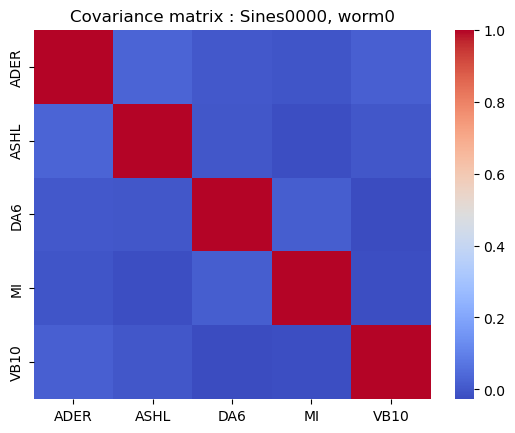

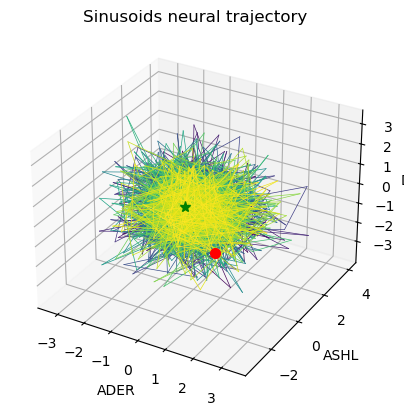

In [11]:
# Plotting dataset
plot_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle="Synthetic dataset - {}".format(worm_idx),
)

# Visualize covariance matrix
data = dataset[worm_idx]["smooth_calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {file_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(
    X, axis_labels=tuple(neurons[:3]), title="Sinusoids neural trajectory"
)

#### Time delay embedding
---

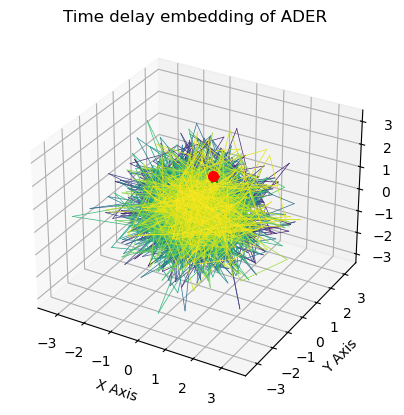

In [12]:
# Example usage:
# Let's assume you have a time series data stored in a variable called `time_series_data`.
idx = 0
time_series_data = X[:, idx]
# You would first determine `tau` and `m` based on your data.

tau = 5  # replace with the delay you've computed or chosen
m = 3  # replace with the embedding dimension you've computed or chosen

# You can then compute the time-delay embedding of your data as follows:
embedded_data = time_delay_embedding(time_series_data, tau, m)
plot_3d_trajectory(embedded_data, title=f"Time delay embedding of {neurons[idx]}")

#### Lorenz dataset
---

In [188]:
def create_synthetic_dataset_lorenz(
    max_timesteps=1000,
    num_worms=1,
    num_signals=302,
    add_noise=False,
    noise_std=0.01,
    num_lorenz_systems=1,
    fine_integration_step=0.1,
    delta_seconds=0.7,
    smooth_method="GA",
    transform=StandardScaler(),
    dataset_name="Lorenz0000",
):
    """
    Create a synthetic worm datasets using the Lorenz attractor.
    Three neurons are chosen randomly to represent x, y, z trajectories from the Lorenz system.

    :param seq_len: The sequence length of the synthetic data.
    :param num_worms: The number of worms to create datasets for.
    :param num_signals: The number of signals, corresponds to number of neurons.
    :param add_noise: If True, add Gaussian noise to the synthetic data.
    :param noise_std: The sklearn transform to use for normalizing the data.
    :param num_lorenz_systems: The number of Lorenz systems to use for creating the synthetic data.
    :param fine_integration_step: The integration step size for the Lorenz system.
    :param delta_seconds: The constant time difference (in seconds) between each measurement of the system.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: Standard deviation of the Gaussian noise.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Calculation of named and unknown neurons
    num_named_neurons = num_lorenz_systems * 3
    num_unknown_neurons = num_signals - num_named_neurons

    # Fine integration time points
    fine_time_points = np.arange(
        0, max_timesteps * delta_seconds, fine_integration_step
    )

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        calcium_data = np.zeros((max_timesteps, num_signals))

        # Create multiple Lorenz systems
        for system_idx in range(num_lorenz_systems):
            # Define a new set of initial conditions for each Lorenz system
            system_initial_conditions = np.random.rand(
                3
            )  # or other method to generate initial conditions

            # Integrate the Lorenz system
            fine_trajectories = odeint(
                lorenz, system_initial_conditions, fine_time_points
            )

            # Downsampling to get the sampled data at delta_seconds intervals
            downsample_indices = np.arange(
                0, len(fine_time_points), int(delta_seconds / fine_integration_step)
            )

            # Downsample and assign to neurons as before
            sampled_trajectories = fine_trajectories[downsample_indices]

            # Assign to the correct set of neurons for this Lorenz system
            for i in range(3):
                neuron_index = named_neuron_indices[system_idx * 3 + i]
                calcium_data[:, neuron_index] = sampled_trajectories[:, i]

                # Optionally add noise
                if add_noise:
                    calcium_data[:, neuron_index] += np.random.normal(
                        0, noise_std, max_timesteps
                    )

        # Normalize data
        calcium_data = transform.fit_transform(calcium_data)

        # Calculate residuals
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        resample_dt = np.round(np.median(dt).item(), 2)
        residual_calcium = np.gradient(calcium_data, axis=0) / dt

        # Smooth the data
        if smooth_method is not None:
            smooth_calcium_data = smooth_data_preprocess(
                calcium_data, time_in_seconds, smooth_method
            )
            smooth_residual_calcium = smooth_data_preprocess(
                residual_calcium, time_in_seconds, smooth_method
            )
        else:
            smooth_calcium_data = calcium_data
            smooth_residual_calcium = residual_calcium

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = max_timesteps
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)

        # Save the data
        dataset[worm] = worm_data

    return dataset

In [189]:
# Initialize parameters
max_timesteps = 3000
num_worms = 1
add_noise = False
noise_std = 0.1
num_lorenz_systems = 1
fine_integration_step = 0.01
file_name = "Lorenz0000"
delta_seconds = 0.05
smooth_method = None  # "GA"

# Creating and saving datasets
dataset = create_synthetic_dataset_lorenz(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=302,
    add_noise=add_noise,
    noise_std=noise_std,
    num_lorenz_systems=num_lorenz_systems,
    fine_integration_step=fine_integration_step,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=StandardScaler(),
    dataset_name=file_name,
)

# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][
    : num_lorenz_systems * 3
]

# Save the dataset
save_synthetic_dataset(f"processed/neural/{file_name}.pickle", dataset)

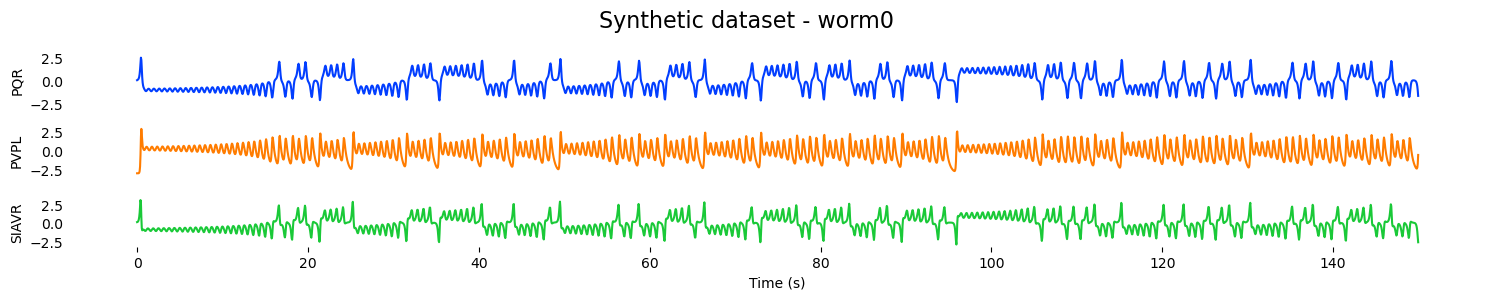

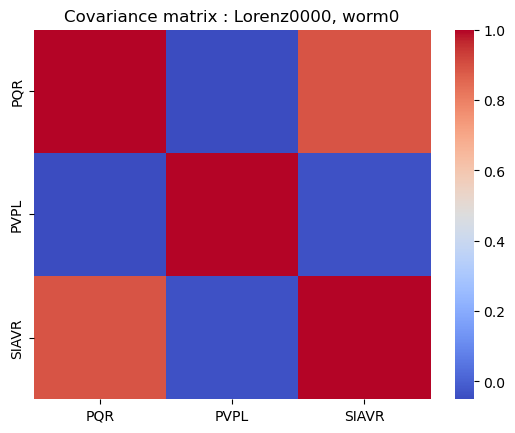

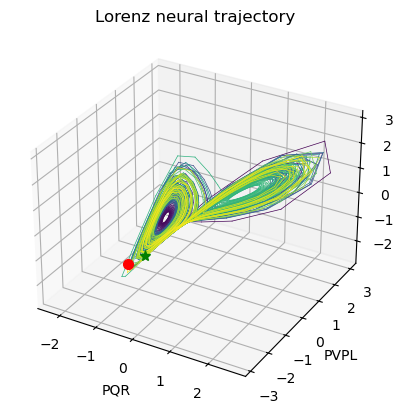

In [190]:
# Plotting dataset
plot_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle="Synthetic dataset - {}".format(worm_idx),
)

# Visualize covariance matrix
data = dataset[worm_idx]["smooth_calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {file_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title="Lorenz neural trajectory")

### Time-delay embedding
---

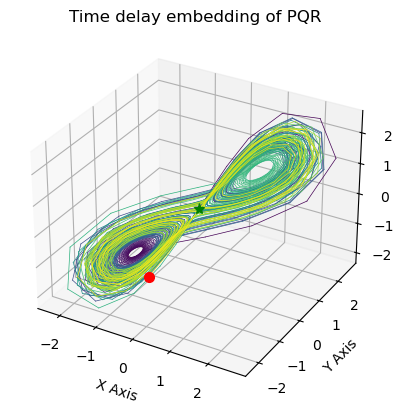

In [191]:
# Example usage:
# Let's assume you have a time series data stored in a variable called `time_series_data`.
idx = 0
time_series_data = X[:, idx]
# You would first determine `tau` and `m` based on your data.

tau = 1  # replace with the delay you've computed or chosen
m = 3  # replace with the embedding dimension you've computed or chosen

# You can then compute the time-delay embedding of your data as follows:
embedded_data = time_delay_embedding(time_series_data, tau, m)
plot_3d_trajectory(embedded_data, title=f"Time delay embedding of {neurons[idx]}")